In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
# Read the data
df = pd.read_csv('../player_game_statistics.csv')

In [3]:
# Data Preprocessing for Engagement Prediction

# Create separate encoders for each categorical variable
game_encoder = LabelEncoder()
gender_encoder = LabelEncoder()
country_encoder = LabelEncoder()

# Fit the encoders
df['game_encoded'] = game_encoder.fit_transform(df['game_name'])
df['gender_encoded'] = gender_encoder.fit_transform(df['gender'])
df['country_encoded'] = country_encoder.fit_transform(df['country'])

# Select features for engagement prediction
features = ['total_games_played', 'win_ratio', 
           'gender_encoded', 'country_encoded', 'age', 'game_encoded']

X = df[features]
y = df['total_time_played_minutes']  # Target variable for engagement

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Initialize models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'SVR': SVR(kernel='rbf')
}


Random Forest Results:
RMSE: 78.30
MAE: 55.34
R2 Score: 1.00
Cross-validation R2 scores mean: 0.99


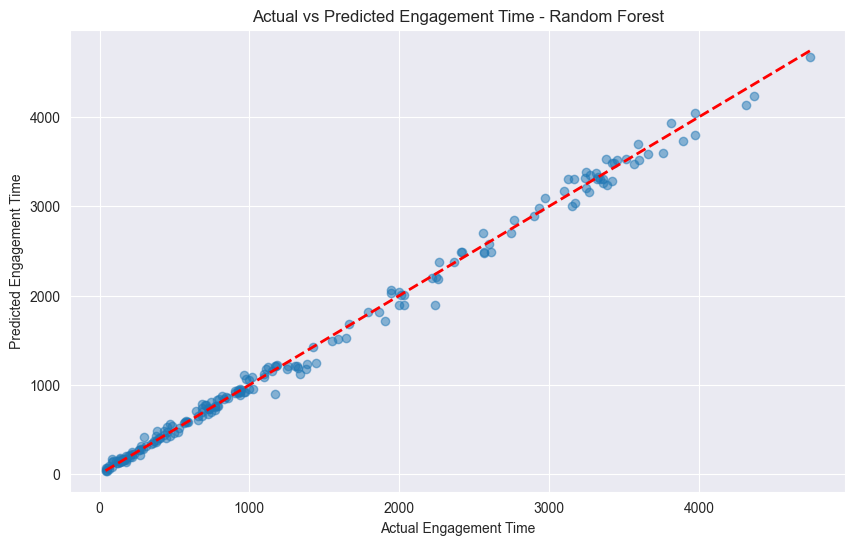


Gradient Boosting Results:
RMSE: 107.94
MAE: 72.50
R2 Score: 0.99
Cross-validation R2 scores mean: 0.99


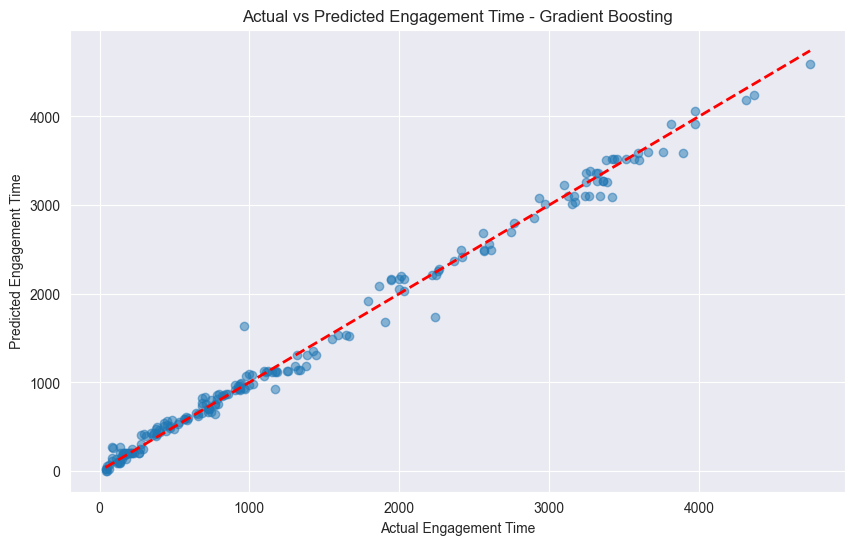


Linear Regression Results:
RMSE: 637.07
MAE: 516.20
R2 Score: 0.73
Cross-validation R2 scores mean: 0.77


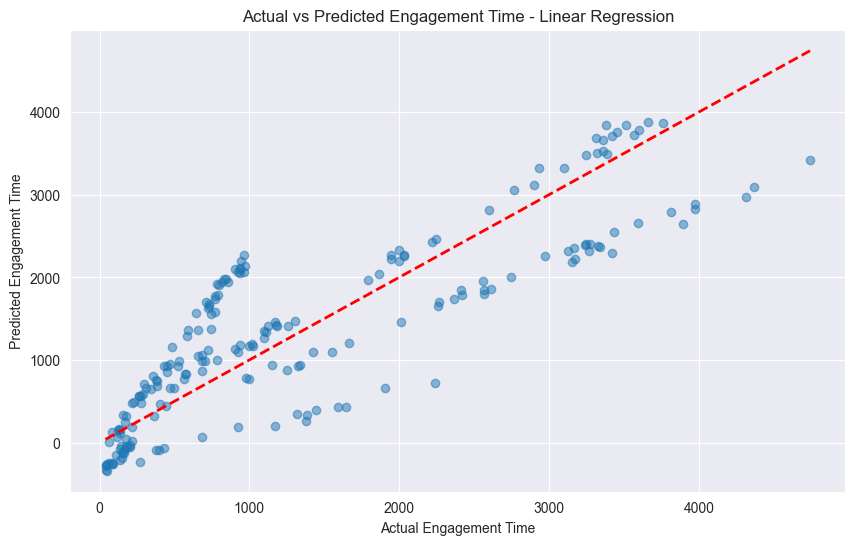


SVR Results:
RMSE: 1282.58
MAE: 921.07
R2 Score: -0.11
Cross-validation R2 scores mean: -0.15


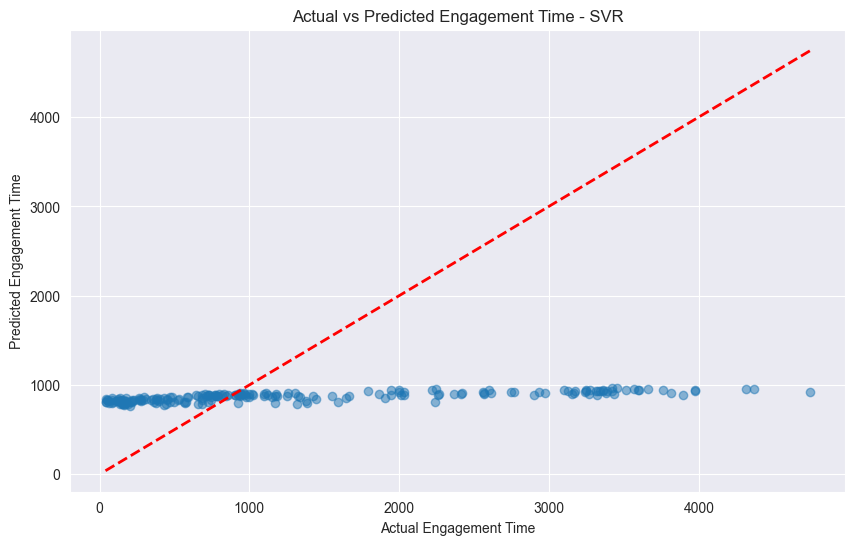

In [7]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    results[name]['CV Scores'] = cv_scores
    
    print(f"\n{name} Results:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.2f}")
    print(f"Cross-validation R2 scores mean: {cv_scores.mean():.2f}")
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Engagement Time')
    plt.ylabel('Predicted Engagement Time')
    plt.title(f'Actual vs Predicted Engagement Time - {name}')
    plt.show()

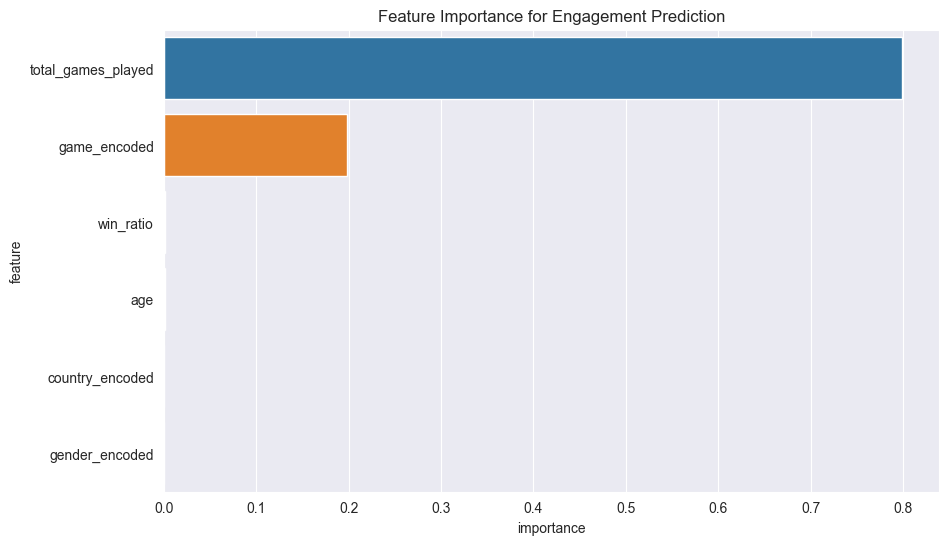

In [8]:
# Feature Importance for Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance for Engagement Prediction')
plt.show()

In [9]:
# First, select the best model based on R2 scores
best_model_name = max(results, key=lambda x: np.mean(results[x]['CV Scores']))
best_model = models[best_model_name]
best_cv_score = np.mean(results[best_model_name]['CV Scores'])

print(f"\nBest Model: {best_model_name}")
print(f"Best Cross-validation R2 Score: {best_cv_score:.4f}")


Best Model: Random Forest
Best Cross-validation R2 Score: 0.9949


In [10]:
# Save the best model
with open('../models/engagement_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save the scaler
with open('../models/engagement_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the encoders
encoder_dict = {
    'game_encoder': game_encoder,
    'gender_encoder': gender_encoder,
    'country_encoder': country_encoder
}

with open('../models/engagement_encoders.pkl', 'wb') as f:
    pickle.dump(encoder_dict, f)

In [11]:
def load_engagement_model():
    """Load the saved engagement prediction model and preprocessing objects"""
    with open('../models/engagement_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    with open('../models/engagement_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    with open('../models/engagement_encoders.pkl', 'rb') as f:
        encoders = pickle.load(f)
    
    return model, scaler, encoders

def predict_engagement(data, model, scaler, encoders):
    """
    Make engagement predictions on new data
    
    Parameters:
    data (pd.DataFrame): DataFrame containing the required features
    model: Loaded model
    scaler: Loaded scaler
    encoders: Dictionary of loaded label encoders
    
    Returns:
    np.array: Predicted engagement time in minutes
    """
    # Preprocess the data
    data_processed = data.copy()
    
    # Encode categorical variables
    data_processed['game_encoded'] = encoders['game_encoder'].transform(data_processed['game_name'])
    data_processed['gender_encoded'] = encoders['gender_encoder'].transform(data_processed['gender'])
    data_processed['country_encoded'] = encoders['country_encoder'].transform(data_processed['country'])
    
    # Select features
    features = ['total_games_played', 'win_ratio','gender_encoded', 'country_encoded', 'age', 'game_encoded']
    
    X = data_processed[features]
    X_scaled = scaler.transform(X)
    
    # Make predictions
    return model.predict(X_scaled)

In [12]:
# Test with new data
print("\nTesting model with new data:")

# Create sample test data
test_data = pd.DataFrame({
    'game_name': ['reversi'],
    'total_games_played': [2],
    'win_ratio': [50.00],
    'gender': ['Male'],
    'country': ['China'],
    'age': [51]
})

# Load model and components
model, scaler, encoders = load_engagement_model()

# Make prediction
prediction = predict_engagement(test_data, best_model, scaler, encoder_dict)
print(f"Predicted engagement time: {prediction[0]:.2f} minutes")


Testing model with new data:
Predicted engagement time: 27.11 minutes


In [13]:
# Test with new data
print("\nTesting model with new data:")

# Create sample test data
test_data = pd.DataFrame({
    'game_name': ['chess'],
    'total_games_played': [89],
    'win_ratio': [28.09],
    'gender': ['Male'],
    'country': ['USA'],
    'age': [50]
})

# Load model and components
model, scaler, encoders = load_engagement_model()

# Make prediction
prediction = predict_engagement(test_data, best_model, scaler, encoder_dict)
print(f"Predicted engagement time: {prediction[0]:.2f} minutes")


Testing model with new data:
Predicted engagement time: 3506.52 minutes


In [15]:
# Test with new data
print("\nTesting model with new data:")

# Create sample test data
test_data = pd.DataFrame({
    'game_name': ['chess'],
    'total_games_played': [28],
    'win_ratio': [53.57],
    'gender': ['Male'],
    'country': ['Canada'],
    'age': [18]
})

# Load model and components
model, scaler, encoders = load_engagement_model()

# Make prediction
prediction = predict_engagement(test_data, best_model, scaler, encoder_dict)
print(f"Predicted engagement time: {prediction[0]:.2f} minutes")


Testing model with new data:
Predicted engagement time: 1139.50 minutes
